<a href="https://colab.research.google.com/github/eridanletalis/GB_nn/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade pip
#!pip uninstall -y tensorflow-gpu
#!pip install tensorflow-gpu==2.4.1
#%tensorflow_version 2.4.1

#По традиции кидаемся в бой, не читая и сначала выполняем дз из pdf
#Улучшение работы нейросети на fashion-mnist

Подключаем библиотеки и подгружаем данные

In [83]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [84]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [85]:
# Проверим, что ГПУ включился
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.82764212499751
GPU (s):
0.03981853699951898
GPU speedup over CPU: 71x


In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [86]:
# сразу подключим оптимизаторы, слои и прочее
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
import tensorflow

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

Загружаем исходные данные

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
y_train_labels = to_categorical(train_labels)
y_test_labels = to_categorical(test_labels)

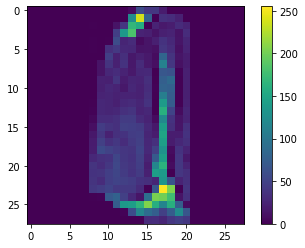

In [ ]:
plt.figure()
plt.imshow(train_images[8879])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

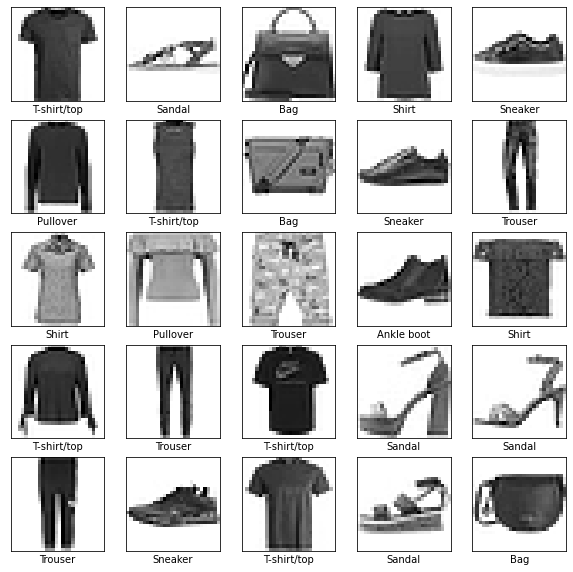

In [ ]:
plt.figure(figsize=(10,10))
for i in range(154,179):
    plt.subplot(5,5,i+1-154)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Строим ИНС
Помня о том, что во второй работе увеличение колиества нейронов в слое не давало высокого прироста, а чрезмерное увеличение количества слоёв увеличивало переобучение, применим копромисное решение.

<strong>Вывод первый интересный: как и в биологической системе, в информационной решающее значение оказвыает число узлов нейронов - синапсов. Это увеличивает разнообразие возможных состояний сети.</strong>

<strong>Наблюдение из прошлого дз : чем больше нейронных связей, тем больше (до определённого предела) потребуется эпох, чтобы ИНС обучилась. Смотреть за переобучением можно с использованием <i>не рассмотренной на лекции</i> callback функции monitor. </strong> Реализовывать не стал - не успел.


In [ ]:
# Количество слоёв выбиралось исходя из уменьшения вдвое числа входов
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(392, activation='relu'),
    keras.layers.Dense(196, activation='relu'),
    keras.layers.Dense(98, activation='relu'),
    keras.layers.Dense(49, activation='relu'),
    keras.layers.Dense(10)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_2 (Dense)              (None, 98)                19306     
_________________________________________________________________
dense_3 (Dense)              (None, 49)                4851      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                500       
Total params: 409,405
Trainable params: 409,405
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Путём тестов выяснил, что аккуратность не растёт сильно после 18 эпохи
model.fit(train_images, y_train_labels, epochs=18, batch_size=100)

Epoch 1/18
600/600 [==============================] - 2s 3ms/step - loss: 0.6696 - accuracy: 0.7655
Epoch 2/18
600/600 [==============================] - 2s 3ms/step - loss: 0.3678 - accuracy: 0.8640
Epoch 3/18
600/600 [==============================] - 1s 2ms/step - loss: 0.3340 - accuracy: 0.8748
Epoch 4/18
600/600 [==============================] - 1s 2ms/step - loss: 0.3046 - accuracy: 0.8881
Epoch 5/18
600/600 [==============================] - 1s 2ms/step - loss: 0.2854 - accuracy: 0.8912
Epoch 6/18
600/600 [==============================] - 2s 3ms/step - loss: 0.2655 - accuracy: 0.9002
Epoch 7/18
600/600 [==============================] - 2s 3ms/step - loss: 0.2584 - accuracy: 0.9017
Epoch 8/18
600/600 [==============================] - 2s 3ms/step - loss: 0.2490 - accuracy: 0.9045
Epoch 9/18
600/600 [==============================] - 2s 3ms/step - loss: 0.2350 - accuracy: 0.9105
Epoch 10/18
600/600 [==============================] - 2s 3ms/step - loss: 0.2249 - accuracy: 0.9143

In [ ]:
# Добившись немного лучших показателей, чем на лекции, решил остановиться на этом варианте сети
test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3514 - accuracy: 0.8878

Test accuracy: 0.8877999782562256


In [ ]:
y_p = model.predict(test_images[:1,:,:])
y_p

array([[-6.830739 , -2.8214622, -7.749578 , -8.473998 , -7.426876 ,
         1.096839 , -7.4103546,  3.175654 , -7.019154 ,  8.532133 ]],
      dtype=float32)

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

In [ ]:
np.argmax(predictions[0])

9

In [ ]:
test_labels[0]

9

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

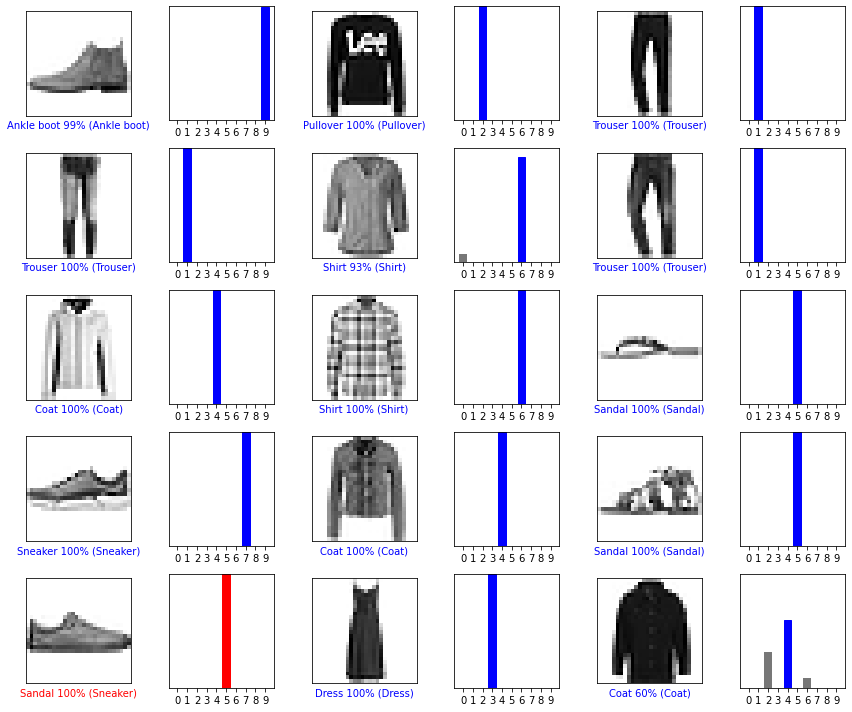

In [ ]:

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

#Теперь поработаем с тестами разных оптимизаторов для подобранной сети

In [89]:
import pandas as pd
from datetime import datetime
from tensorflow.keras import initializers

In [ ]:
columns_1 = ("adam", "sgd", "rmsprop", "adagrad")
models_loss = pd.DataFrame(columns=columns_1)
models_acc = pd.DataFrame(columns=columns_1)

In [ ]:
optimizers = ["adam", "sgd", "rmsprop", "adagrad"]

## Выполняем эксперимент на определение лучшего оптимизатора
Эксперимент будет выпоняться 15 раз с разными seed для усреднения при разных начальных состояниях. 
Записываем loss, acc.

Далее результат будет усреднён и выбрана модель с наилучшей комбинацией loss-acc. Учитываться будут средние значения и дисперсии.

In [ ]:
# Количество слоёв выбиралось исходя из уменьшения вдвое числа входов
for i in range(1,16):
  for opt in optimizers:
    print(f"Выполняется проход {i}, оптимизатор {opt}")
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(392, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dense(196, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dense(98, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dense(49, activation='relu',
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp()))),
        keras.layers.Dense(10,
                           kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                  stddev=0.15, 
                                      seed=int(datetime.now().timestamp())))
    ])

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_images, y_train_labels, epochs=18, batch_size=100, verbose=0)

    test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
    models_loss.loc[i, opt] = test_loss
    models_acc.loc[i, opt] = test_acc

In [ ]:
models_loss.astype(np.float64).describe()


,number,adam,sgd,rmsprop,adagrad
count,0.0,15.000000,15.000000,15.000000,15.000000
mean,NaN,0.365343,0.398260,0.542421,0.476739
std,NaN,0.017400,0.011235,0.075551,0.007278
min,NaN,0.342492,0.380655,0.461082,0.460936
25%,NaN,0.351179,0.391990,0.490254,0.472842
50%,NaN,0.364625,0.395093,0.516232,0.477284
75%,NaN,0.379016,0.405072,0.566593,0.481073
max,NaN,0.390581,0.417477,0.722251,0.486720


In [ ]:
models_acc.astype(np.float64).describe()

,number,adam,sgd,rmsprop,adagrad
count,0.0,15.000000,15.000000,15.000000,15.000000
mean,NaN,0.888233,0.858287,0.879073,0.832593
std,NaN,0.003714,0.003984,0.007427,0.003009
min,NaN,0.880000,0.849800,0.864000,0.828800
25%,NaN,0.886200,0.857050,0.877100,0.830550
50%,NaN,0.888900,0.859300,0.881700,0.831200
75%,NaN,0.889750,0.860750,0.884200,0.834450
max,NaN,0.894800,0.862900,0.887000,0.839500


По совокупности факторов лучшим оптимизатором для этой сети выходит adam.
следующие эксперименты будут использовать этот оптимизатор, кроме эксперимента с разными функциями потерь

<strong>Наблюдение 2: У Adam самый высокий разброс loss, но низкий разброс Accuracy значений. Случайность это или закономерность, нужно проверить. </strong>

Выполнен опыт, но число запусков было 100:
1. 50 запусков с изменением зерна
2. 50 запусков без изменения зерна.

При изменении зерна для инициализации у Adam разброс потерь такой же низки, но разброс значений аккурантости ниже у adagrad. При этом средние у adagrad гораздо хуже, чем у Adam

Интерпретировать результаты не получается. При изменении зерна разброс большой и я не могу утверждать, что он как-то отличается от запусков с изменением зерна.
Подробности эксперимента есть по ссылке

https://github.com/eridanletalis/GB_nn/blob/main/%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D1%83%D1%82%D0%B2%D0%B5%D1%80%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D1%80%D0%BE_Adam.ipynb

Возможно, вы мне сможете рассказать, что происходит.

#Выполняем эксперимент на выявление лучшей структуры ИНС

Текущую модель примем за базовую и выполним проверку с моделями, у которых:
1. Добавлены два слоя на перед первым (392*4,392*2)
2. Добавлен слой перед первым (392*2)
3. Убран первый слой 
4. Убран первый и второй слои


Примечание: после тестового запуска решил увеличить число эпох для х4 до 23, для х2 до 20. Для х0,25 уменьшить до 15

In [26]:
columns_2 = ("x4", "x2", "baseline", "x0.5", "x0.25")
models_loss = pd.DataFrame(columns=columns_2)
models_acc = pd.DataFrame(columns=columns_2)

In [27]:
models_acc

,x4,x2,baseline,x0.5,x0.25


In [28]:
models_loss

,x4,x2,baseline,x0.5,x0.25


In [29]:
print(392*4)
print(392*2)

1568
784


In [30]:
# Добившись немного лучших показателей, чем на лекции, решил остановиться на этом варианте сети
for i in range(1, 16):
  print(f"Выполняется проход {i} сеть х4")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(1568, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(784, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(392, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=23, batch_size=100, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x4"] = test_loss
  models_acc.loc[i, "x4"] = test_acc

  print(f"Выполняется проход {i} сеть х2")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(784, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(392, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=20, batch_size=100, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x2"] = test_loss
  models_acc.loc[i, "x2"] = test_acc

  print(f"Выполняется проход {i} сеть baseline")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(392, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=18, batch_size=100, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "baseline"] = test_loss
  models_acc.loc[i, "baseline"] = test_acc
 
  print(f"Выполняется проход {i} сеть x0.5")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(196, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=18, batch_size=100, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x0.5"] = test_loss
  models_acc.loc[i, "x0.5"] = test_acc

  print(f"Выполняется проход {i} сеть x0.25")
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(28, 28)),
      keras.layers.Dense(98, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(49, activation='relu',
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp()))),
      keras.layers.Dense(10,
                          kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                stddev=0.15, 
                                    seed=int(datetime.now().timestamp())))
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model.fit(train_images, y_train_labels, epochs=15, batch_size=100, verbose=0)

  test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
  models_loss.loc[i, "x0.25"] = test_loss
  models_acc.loc[i, "x0.25"] = test_acc


Выполняется проход 1 сеть х4


NameError: ignored

In [ ]:
models_loss.astype(np.float64).describe()

In [ ]:
models_acc.astype(np.float64).describe()

Модель x0.25 показала наилучшие результаты. у неё самый низкий показатель функции потерь и самый низкий разброс при разных начальных значениях. Она будет использована при проверках на разные функции потерь

# Выполняем тестирование функций потерь

In [ ]:
models_loss = pd.DataFrame(columns=columns_1)
models_acc = pd.DataFrame(columns=columns_1)

models_loss_std = pd.DataFrame(columns=columns_1)
models_acc_std = pd.DataFrame(columns=columns_1)

In [ ]:
models_loss

,adam,sgd,rmsprop,adagrad


In [ ]:
models_loss_std

,adam,sgd,rmsprop,adagrad


In [ ]:
models_acc

,adam,sgd,rmsprop,adagrad


In [ ]:
models_acc_std

,adam,sgd,rmsprop,adagrad


In [ ]:
optimizers

['adam', 'sgd', 'rmsprop', 'adagrad']

In [ ]:
catcrosstrue = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
catcrossfalse = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cathinge = tf.keras.losses.CategoricalHinge()
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
msle = tf.keras.losses.MeanSquaredLogarithmicError()
poison = tf.keras.losses.Poisson()
kld = tf.keras.losses.KLDivergence()
losses = [catcrosstrue, catcrossfalse, cathinge, cathinge, mae, mse, msle, poison, kld]
losses_names = ["catcrosstrue", "catcrossfalse", "cathinge", "cathinge", "mae", "mse", "msle", "poison", "kld"]
losses

In [ ]:
losses_names

['catcrosstrue',
 'catcrossfalse',
 'cathinge',
 'cathinge',
 'mae',
 'mse',
 'msle',
 'poison',
 'kld']

In [ ]:
for j,ls in enumerate(losses):
  for opt in optimizers:
    loss_tst = []
    acc_tst = []
    for i in range(1,16):
      print(f"Выполняется проход {i} сеть x0.25, оптимизатор {opt}, \
      функция потерь {ls}")
      model = keras.Sequential([
          keras.layers.Flatten(input_shape=(28, 28)),
          keras.layers.Dense(98, activation='relu',
                              kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                    stddev=0.15, 
                                        seed=int(datetime.now().timestamp()))),
          keras.layers.Dense(49, activation='relu',
                              kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                    stddev=0.15, 
                                        seed=int(datetime.now().timestamp()))),
          keras.layers.Dense(10,
                              kernel_initializer=initializers.RandomNormal(mean=0.0, 
                                                                    stddev=0.15, 
                                        seed=int(datetime.now().timestamp())))
      ])

      model.compile(optimizer=opt,
                    loss=ls,
                    metrics=['accuracy'])

      model.fit(train_images, y_train_labels, epochs=15, batch_size=100, verbose=0)

      test_loss, test_acc = model.evaluate(test_images,  y_test_labels, verbose=2)
      loss_tst.append(test_loss)
      acc_tst.append(test_acc)

    models_loss.loc[losses_names[j], opt] = np.array(loss_tst).mean()
    models_acc.loc[losses_names[j], opt] = np.array(test_acc).mean()
    models_loss_std.loc[losses_names[j], opt] = np.array(loss_tst).std()
    models_acc_std.loc[losses_names[j], opt] = np.array(test_acc).std()

Выполняется проход 1 сеть x0.25, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x7f368143a1d0>
313/313 - 1s - loss: 0.3407 - accuracy: 0.8847
Выполняется проход 2 сеть x0.25, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x7f368143a1d0>
313/313 - 1s - loss: 0.3641 - accuracy: 0.8770
Выполняется проход 3 сеть x0.25, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x7f368143a1d0>
313/313 - 1s - loss: 0.3584 - accuracy: 0.8799
Выполняется проход 4 сеть x0.25, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x7f368143a1d0>
313/313 - 1s - loss: 0.3589 - accuracy: 0.8793
Выполняется проход 5 сеть x0.25, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x7f368143a1d0>
313/313 - 1s - loss: 0.3379 - accuracy: 0.

In [ ]:
models_loss
 

,adam,sgd,rmsprop,adagrad
catcrosstrue,0.348254,0.451775,0.365174,0.599851
catcrossfalse,9.2172,NaN,9.26405,NaN
cathinge,0.284565,0.374486,0.286805,0.479678
mae,0.0995834,0.0969639,0.0981686,0.110102
mse,0.0194901,0.0465766,0.0184522,0.0704292
msle,0.0208271,0.0372732,0.0213503,0.0404985
poison,NaN,NaN,NaN,NaN
kld,0.967077,0.75223,0.752163,0.971343


In [ ]:
models_acc


,adam,sgd,rmsprop,adagrad
catcrosstrue,0.8821,0.8391,0.8827,0.7932
catcrossfalse,0.2288,0.1,0.1442,0.1324
cathinge,0.8832,0.8407,0.877,0.7893
mae,0.1,0.4677,0.1,0.1077
mse,0.8741,0.7059,0.8827,0.6145
msle,0.6306,0.45,0.6281,0.3104
poison,0.1,0.1,0.1,0.1
kld,0.2608,0.1648,0.1132,0.0994


In [ ]:
models_loss_std


,adam,sgd,rmsprop,adagrad
catcrosstrue,0.00991461,0.00683818,0.0125472,0.012875
catcrossfalse,1.74987,NaN,1.00289,NaN
cathinge,0.00771206,0.00287927,0.00720601,0.00507687
mae,0.00200776,0.00476404,0.00473204,0.0148244
mse,0.000570126,0.00132032,0.000290501,0.00231166
msle,0.00645311,0.00319995,0.00386062,0.00254976
poison,NaN,NaN,NaN,NaN
kld,0.984829,0.996478,0.996488,1.41604


In [ ]:
models_acc_std

,adam,sgd,rmsprop,adagrad
catcrosstrue,0,0,0,0
catcrossfalse,0,0,0,0
cathinge,0,0,0,0
mae,0,0,0,0
mse,0,0,0,0
msle,0,0,0,0
poison,0,0,0,0
kld,0,0,0,0


# Вывод
Проведённый эксперимент показал, что опять для поиска лучших значений необходимо проверять абсолютно все параметры.
Не совсем ясно, до какого предела увеличивать "слойность" сети.
Предполагаю, что при изменении глубины слоёв будут разные значения для разных оптимизаторв, функций потерь и соответствующих функций активации.

Оптимизатор Adam показывает лучшие результаты по точности и потерям, но средние по разбросу (неустойчивости результатов при серии запусков).

Почему - не понятно.


# Работаем с данными sklearn.datasets import load_boston

In [87]:
data = tf.keras.datasets.boston_housing.load_data()

In [88]:
(train_x,train_y),(test_x,test_y) = data

In [14]:
train_x

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [15]:
model = tf.keras.models.Sequential([
Dense(169,"relu",input_shape=(train_x.shape[-1],)),
Dense(1)
])
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 169)               2366      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 170       
Total params: 2,536
Trainable params: 2,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_x, train_y, epochs=100, 
          validation_data=(test_x[51:],test_y[51:]))

Epoch 1/100
13/13 [==============================] - 1s 17ms/step - loss: 336.1930 - mae: 12.8346 - val_loss: 165.9546 - val_mae: 9.9234
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 90.8970 - mae: 7.4327 - val_loss: 372.7387 - val_mae: 16.9881
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 121.8099 - mae: 8.5829 - val_loss: 85.5739 - val_mae: 7.3141
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 116.9444 - mae: 8.4806 - val_loss: 142.3822 - val_mae: 9.0793
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 91.0910 - mae: 7.3499 - val_loss: 84.4324 - val_mae: 7.5275
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 103.4029 - mae: 8.0053 - val_loss: 74.2817 - val_mae: 6.5293
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 74.2023 - mae: 6.2446 - val_loss: 73.5415 - val_mae: 6.4387
Epoch 8/100
13/13 [==============================] - 0s 6ms

In [ ]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 0s 3ms/step - loss: 34.8914 - mae: 4.0998


[34.89143371582031, 4.099792957305908]

Текущий результат запишем как опорный и начнём экспериметы.

# Эксперимент с увеличением количества слоёв

Будет создано 5 разных ИНС:
1. Один слой, число нейронов 13
2. Один слой, число нейронов 26
3. Один слой, число нейронов 52
4. Один слой, число нейронов 13x13
5. Два слоя, число нейронов 13x13, 13
6. Два слоя, число нейронов 13x13, 13x13
7. Три слоя, число нейронов 52, 26, 13
8. Три слоя, число нейронов 13x13, 13x13, 13x13
9. Десять слоёв, число нейронов 13 в каждом
10. Десять слоёв, число нейронов 13x13 в каждом

Эксперимент будет запущен 15 раз каждый и вычислены среднее и дисперсии метрик. 
Фиксируем число эпох - 200 и критерий mae

Сначала работаем с relu, затем с sigmoid

In [ ]:
columns_1 = [
             "1-13",
             "1-26",
             "1-52",
             "1-13x13",
             "1-13x13,2-13",
             "1-13x13,2-13x13",
             "1-52,2-26,3-13",
             "1-13x13,2-13x13,3-13x13",
             "x10-13",
             "x10-13x13"
]
models_loss = pd.DataFrame(columns=columns_1)
models_mae = pd.DataFrame(columns=columns_1)

# models_loss_std = pd.DataFrame(columns=columns_1)
# models_mae_std = pd.DataFrame(columns=columns_1)

In [ ]:
models_loss

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13


In [ ]:
for i in range (1,16):
  print(f"Выполняется проход {i}, сеть {columns_1[0]}")
  model = tf.keras.models.Sequential([
  Dense(13,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[0]] = loss
  models_mae.loc[i, columns_1[0]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")
  model = tf.keras.models.Sequential([
  Dense(26,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[1]] = loss
  models_mae.loc[i, columns_1[1]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(52,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[2]] = loss
  models_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[3]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[3]] = loss
  models_mae.loc[i, columns_1[3]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[4]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(13,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[4]] = loss
  models_mae.loc[i, columns_1[4]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[5]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(169,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[5]] = loss
  models_mae.loc[i, columns_1[5]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[6]}")
  model = tf.keras.models.Sequential([
  Dense(52,"relu",input_shape=(train_x.shape[-1],)),
  Dense(26,"relu"),
  Dense(13,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[6]] = loss
  models_mae.loc[i, columns_1[6]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[7]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[7]] = loss
  models_mae.loc[i, columns_1[7]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[8]}")
  model = tf.keras.models.Sequential([
  Dense(13,"relu",input_shape=(train_x.shape[-1],)),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(13,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[8]] = loss
  models_mae.loc[i, columns_1[8]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[9]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],)),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(169,"relu"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[9]] = loss
  models_mae.loc[i, columns_1[9]] = mae

Выполняется проход 1, сеть 1-13
4/4 [==============================] - 0s 4ms/step - loss: 40.1987 - mae: 4.4329
Выполняется проход 1, сеть 1-26
4/4 [==============================] - 0s 4ms/step - loss: 32.4725 - mae: 4.2609
Выполняется проход 1, сеть 1-52
4/4 [==============================] - 0s 5ms/step - loss: 65.4547 - mae: 7.1656
Выполняется проход 1, сеть 1-13x13
4/4 [==============================] - 0s 6ms/step - loss: 53.4522 - mae: 5.7425
Выполняется проход 1, сеть 1-13x13,2-13
4/4 [==============================] - 0s 4ms/step - loss: 27.1433 - mae: 3.6342
Выполняется проход 1, сеть 1-13x13,2-13x13
4/4 [==============================] - 0s 4ms/step - loss: 29.9795 - mae: 3.9153
Выполняется проход 1, сеть 1-52,2-26,3-13
4/4 [==============================] - 0s 4ms/step - loss: 48.8454 - mae: 5.3682
Выполняется проход 1, сеть 1-13x13,2-13x13,3-13x13
4/4 [==============================] - 0s 4ms/step - loss: 32.7522 - mae: 4.0094
Выполняется проход 1, сеть x10-13
4/4 [======

In [ ]:
models_loss


,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
1,40.1987,32.4725,65.4547,53.4522,27.1433,29.9795,48.8454,32.7522,36.3678,29.9038
2,42.9094,51.6481,33.6547,37.6081,29.581,28.9385,29.325,56.2853,40.0325,27.8837
3,32.7491,51.5318,34.5021,75.1541,28.0472,25.82,29.2503,40.3937,29.7353,31.5772
4,45.8876,33.1564,33.3391,27.6071,43.8622,32.4797,34.6019,32.4353,40.4196,46.8762
5,32.1864,34.2331,35.9075,52.8376,31.9948,28.1395,31.2253,47.3319,37.3052,52.9928
6,30.9147,32.7678,39.3604,45.6754,28.5511,33.6305,40.6462,27.5399,32.2548,29.9111
7,33.7121,32.3395,66.9759,29.5759,25.9997,30.7542,51.3047,30.6193,33.9484,36.6602
8,33.7932,52.202,52.5044,68.9943,30.2567,28.489,25.2024,43.6605,32.1493,35.7358
9,36.101,36.1896,30.472,70.5269,31.6073,58.5841,35.2019,52.0853,35.3361,82.5533
10,32.5566,32.9744,34.721,164.079,27.2616,25.2279,27.9202,31.0136,36.9866,28.2832


In [ ]:
models_mae

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
1,4.4329,4.26089,7.16559,5.74245,3.63422,3.91533,5.36821,4.00941,4.29275,3.71887
2,5.18787,6.10885,4.0934,4.46111,3.81008,3.76993,3.74226,4.89649,4.35872,3.42104
3,4.2175,6.17065,4.15887,7.1073,3.71456,3.46479,3.68916,4.26007,3.74479,3.68526
4,4.76292,3.92298,4.12432,3.71647,4.7399,3.8961,4.40508,3.91799,4.46405,4.88926
5,3.85663,4.29701,4.75057,6.08776,4.02693,3.47254,4.0885,4.86034,4.42723,5.48213
6,4.21424,4.38831,5.046,5.39551,3.65554,3.97419,4.71764,3.38977,3.98851,3.79122
7,4.22599,4.50069,6.71028,3.90421,3.55033,3.57418,5.44632,3.61068,4.05025,4.32961
8,4.18944,6.22402,6.19433,7.0744,3.86408,3.49573,3.65578,4.42467,4.2357,4.14138
9,4.52567,4.3183,3.8784,7.51319,3.99167,5.26047,4.16422,5.37256,4.11662,6.32162
10,4.42184,4.46373,4.20523,11.5948,3.51016,3.33412,3.70341,3.59698,4.22922,3.6433


In [ ]:
models_loss.astype(np.float64).describe()

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,36.337614,39.281547,42.579150,53.148780,32.765543,34.514507,33.393057,41.153371,41.934465,39.271790
std,4.674514,9.857532,14.264658,34.771817,6.569796,11.799668,8.079487,13.081328,20.870194,14.154240
min,30.914740,32.008015,28.408119,27.418966,25.999681,25.227934,24.063643,27.539938,29.520054,27.883717
25%,32.950899,32.738344,33.496880,29.685405,28.299116,27.786964,28.224355,31.525142,32.202055,30.744171
50%,33.793232,34.233097,34.720966,45.675449,30.256689,29.979536,31.225302,40.393681,35.336102,35.300911
75%,40.047728,44.259720,50.360353,61.223228,34.547775,35.804001,35.477303,46.460173,38.668844,43.220915
max,45.887569,62.245518,69.340843,164.079224,45.472370,65.027573,51.304688,75.791748,106.814430,82.553307


In [ ]:
models_mae.astype(np.float64).describe()

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,4.397451,4.809443,5.056715,5.629235,4.082012,3.985952,4.112079,4.335081,4.578488,4.358726
std,0.327529,0.972234,1.226016,2.111715,0.534928,0.730976,0.623927,0.789598,1.200295,0.810851
min,3.856625,3.908188,3.676118,3.716465,3.510164,3.334124,3.381278,3.389767,3.744787,3.421042
25%,4.215869,4.258599,4.141597,3.950139,3.685049,3.489996,3.689623,3.696749,4.019381,3.755045
50%,4.352082,4.318297,4.617225,5.395509,3.864084,3.769933,3.907028,4.260068,4.229223,4.141383
75%,4.577963,5.304768,5.996868,6.581082,4.415701,4.108613,4.284651,4.878418,4.392975,4.924339
max,5.187868,6.804037,7.171214,11.594753,5.123027,5.897921,5.446321,6.199863,7.780494,6.321620


In [ ]:
models2_loss = pd.DataFrame(columns=columns_1)
models2_mae = pd.DataFrame(columns=columns_1)

In [ ]:
for i in range (1,16):
  print(f"Выполняется проход {i}, сеть {columns_1[0]}")
  model = tf.keras.models.Sequential([
  Dense(13,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[0]] = loss
  models2_mae.loc[i, columns_1[0]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")
  model = tf.keras.models.Sequential([
  Dense(26,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[1]] = loss
  models2_mae.loc[i, columns_1[1]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(52,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[2]] = loss
  models2_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[3]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[3]] = loss
  models2_mae.loc[i, columns_1[3]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[4]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(13,"sigmoid"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[4]] = loss
  models2_mae.loc[i, columns_1[4]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[5]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[5]] = loss
  models2_mae.loc[i, columns_1[5]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[6]}")
  model = tf.keras.models.Sequential([
  Dense(52,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(26,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[6]] = loss
  models2_mae.loc[i, columns_1[6]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[7]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[7]] = loss
  models2_mae.loc[i, columns_1[7]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[8]}")
  model = tf.keras.models.Sequential([
  Dense(13,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(13,"sigmoid"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[8]] = loss
  models2_mae.loc[i, columns_1[8]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[9]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(169,"sigmoid"),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models2_loss.loc[i, columns_1[9]] = loss
  models2_mae.loc[i, columns_1[9]] = mae

Выполняется проход 1, сеть 1-13
4/4 [==============================] - 0s 4ms/step - loss: 78.6669 - mae: 6.3165
Выполняется проход 1, сеть 1-26
4/4 [==============================] - 0s 4ms/step - loss: 69.6522 - mae: 5.9196
Выполняется проход 1, сеть 1-52
4/4 [==============================] - 0s 4ms/step - loss: 43.9493 - mae: 4.6911
Выполняется проход 1, сеть 1-13x13
4/4 [==============================] - 0s 4ms/step - loss: 23.9171 - mae: 3.4105
Выполняется проход 1, сеть 1-13x13,2-13
4/4 [==============================] - 0s 4ms/step - loss: 41.4162 - mae: 4.3870
Выполняется проход 1, сеть 1-13x13,2-13x13
4/4 [==============================] - 0s 4ms/step - loss: 29.4458 - mae: 3.4461
Выполняется проход 1, сеть 1-52,2-26,3-13
4/4 [==============================] - 0s 4ms/step - loss: 43.7614 - mae: 4.6945
Выполняется проход 1, сеть 1-13x13,2-13x13,3-13x13
4/4 [==============================] - 0s 4ms/step - loss: 28.3666 - mae: 3.4952
Выполняется проход 1, сеть x10-13
4/4 [======

In [ ]:
models2_loss

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
1,78.6669,69.6522,43.9493,23.9171,41.4162,29.4458,43.7614,28.3666,83.7043,83.6758
2,102.085,60.9131,38.4239,25.5435,63.7806,30.3538,45.3427,39.2762,83.6872,83.6605
3,79.3367,71.9823,41.9449,24.4451,83.8166,32.0317,48.4736,45.7375,83.6954,83.782
4,79.8178,61.642,37.6252,25.0649,63.1051,34.2752,34.704,34.5553,83.7012,83.7269
5,85.058,64.5728,31.6202,26.2688,52.2302,47.024,45.0387,33.9831,83.7187,83.8454
6,88.3361,70.5298,44.6229,23.3733,88.2407,26.5908,75.1566,34.7782,83.7461,83.7684
7,79.4003,71.0531,46.2855,27.5871,38.0886,47.795,47.1977,32.0966,83.6972,83.9579
8,92.2978,58.1635,42.8052,25.8874,57.2326,26.9668,46.2899,33.3607,83.7258,83.6612
9,73.6956,73.1001,51.6127,27.6994,40.4175,30.1288,34.5386,33.2872,83.724,83.7133
10,82.1085,72.4232,44.1955,29.2506,43.7875,28.9813,59.6577,29.0531,83.728,83.4445


In [ ]:
models2_mae

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
1,6.31651,5.91957,4.69108,3.41054,4.38696,3.44611,4.69453,3.49517,6.53333,6.535
2,7.30814,5.64478,4.32564,3.72574,5.58843,3.56807,4.91381,4.35938,6.53432,6.53592
3,6.36647,6.11511,4.59884,3.57971,6.52872,3.75692,4.98381,4.8772,6.53384,6.53009
4,6.36527,5.62968,4.39882,3.36963,5.50511,4.15868,4.13537,4.00005,6.5335,6.53236
5,6.52033,5.87216,3.96767,3.57955,4.93698,5.20086,4.93593,3.8009,6.53271,6.52762
6,6.64431,6.02811,4.74446,3.31526,6.63973,3.37939,6.13763,3.87385,6.53155,6.53064
7,6.31683,6.05546,4.91186,3.83047,4.09819,4.80589,4.95464,3.64543,6.53374,6.52353
8,6.83764,5.49783,4.54978,3.50165,5.25463,3.61001,4.76118,3.74688,6.5324,6.53587
9,6.14571,6.14577,5.19256,3.88114,4.26847,3.58779,4.09072,3.75841,6.53248,6.53294
10,6.47747,6.03093,4.6806,3.71906,4.57492,3.58667,5.50932,3.59273,6.53231,6.55141


In [ ]:
models2_loss.astype(np.float64).describe()

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,87.462950,67.766753,41.962673,25.895416,56.561691,32.210555,48.836842,35.972521,83.718299,83.701587
std,17.518574,5.811822,6.490209,1.953439,16.197860,6.471898,10.170310,7.780053,0.021519,0.134579
min,73.695648,58.163502,29.500881,22.556377,38.088612,26.590757,34.538570,28.366550,83.687233,83.444519
25%,79.265812,61.619471,38.024530,24.720699,42.937325,29.213513,44.400063,31.458060,83.699219,83.648460
50%,82.108543,70.250763,42.805214,25.678627,52.230194,30.128839,46.289944,33.983128,83.723900,83.675804
75%,88.490311,72.202747,45.311628,27.453967,64.416546,31.605102,53.802595,38.398813,83.728680,83.775185
max,145.053879,76.650513,53.035271,29.250591,88.240715,47.794998,75.156555,58.565094,83.766914,83.957886


In [ ]:
models2_mae.astype(np.float64).describe()

,1-13,1-26,1-52,1-13x13,"1-13x13,2-13","1-13x13,2-13x13","1-52,2-26,3-13","1-13x13,2-13x13,3-13x13",x10-13,x10-13x13
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,6.696584,5.911157,4.608056,3.559689,5.173904,3.845672,4.969155,4.021695,6.532774,6.534719
std,0.817243,0.222639,0.426842,0.178056,0.804860,0.526815,0.519134,0.590726,0.000968,0.007238
min,6.136057,5.497830,3.834034,3.315262,4.098193,3.379385,4.090720,3.450769,6.530698,6.523534
25%,6.341050,5.701967,4.362229,3.422123,4.614703,3.514984,4.727855,3.619080,6.532282,6.530364
50%,6.477467,6.004379,4.598840,3.535284,4.936983,3.610006,4.954638,3.800896,6.532485,6.534997
75%,6.651670,6.082330,4.828163,3.714820,5.613613,3.969386,5.251272,4.272372,6.533618,6.536659
max,9.455668,6.210443,5.444083,3.881141,6.639731,5.200858,6.137630,5.605091,6.534319,6.551410


Среди ReLu сетей лучшими являются многослойные, либо однослойная с большим числом нейронов. Возможно, это связано с тем, что ReLu линейная и нелинейность данных хорошо повторяется (моделируется, воспроизводится) нелинейностью связей между нейронами.
Среди сетей, построенных на сигмоиде лучшими результатами обладают сети, состоящие из 169 нейронов в слое - одна и двуслойная. Число нейронов выбрано, как квадрат числа входов.

Сети, состоящие из 10 слоёв, обладают лучшей стабильностью, что странно - бОльшее число связей должны были дать бОльшую вариацию решений. Возможно, дело в том, что данные имеют хороший локальный минимум. 

Лушие архитектуры сетей собраны ниже для дальнейшего анализа. 
Также добавлены глубокие сети.

# Эксперименты с выбранными архитектурами ИНС

Целью этого эксперимента является проверка архитектур на устойчивость при разных начальных позициях (разные сиды).

В основном, этот эскперимент выполняется, потому что я увидел у десятислойной сети на сигмоидах низкий разброс потерь и mae. Возможно, это связано с тем, что при такой глубине у сигмоид проявляется проблема с очень небольшой производной. Или это какая-то аномальная устойчивоть. Будет выполнено 30 проходов, вместо 15. Также проверке подвергнуться выбранные архитектуры сетей. 

In [7]:
columns_1 = [
             "1-169ReLu",
             "1-169,2-169ReLu",
             "1-169Sigmoid",
             "1-169,2-169Sigmoid",
             "x10-13Sigmoid",
             "x10-169Sigmoid",
             "x10-13Relu",
             "x10-169Relu"
]
models_loss = pd.DataFrame(columns=columns_1)
models_mae = pd.DataFrame(columns=columns_1)

In [8]:
models_loss


,1-169ReLu,"1-169,2-169ReLu",1-169Sigmoid,"1-169,2-169Sigmoid",x10-13Sigmoid,x10-169Sigmoid,x10-13Relu,x10-169Relu


In [9]:
models_mae

,1-169ReLu,"1-169,2-169ReLu",1-169Sigmoid,"1-169,2-169Sigmoid",x10-13Sigmoid,x10-169Sigmoid,x10-13Relu,x10-169Relu


In [18]:
for i in range (1,31):
  print(f"Выполняется проход {i}, сеть {columns_1[0]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu", input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[0]] = loss
  models_mae.loc[i, columns_1[0]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[1]] = loss
  models_mae.loc[i, columns_1[1]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[2]] = loss
  models_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[3]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[3]] = loss
  models_mae.loc[i, columns_1[3]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[4]}")
  model = tf.keras.models.Sequential([
  Dense(13,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[4]] = loss
  models_mae.loc[i, columns_1[4]] = mae


  print(f"Выполняется проход {i}, сеть {columns_1[5]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],)),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"sigmoid", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[5]] = loss
  models_mae.loc[i, columns_1[5]] = mae


  print(f"Выполняется проход {i}, сеть {columns_1[6]}")
  model = tf.keras.models.Sequential([
  Dense(13,"relu",input_shape=(train_x.shape[-1],)),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(13,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[6]] = loss
  models_mae.loc[i, columns_1[6]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[7]}")
  model = tf.keras.models.Sequential([
  Dense(169,"relu",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[7]] = loss
  models_mae.loc[i, columns_1[7]] = mae

Выполняется проход 1, сеть 1-169ReLu
4/4 [==============================] - 0s 3ms/step - loss: 30.5635 - mae: 4.3168
Выполняется проход 1, сеть 1-169,2-169ReLu
4/4 [==============================] - 0s 3ms/step - loss: 29.2190 - mae: 3.7250
Выполняется проход 1, сеть 1-169Sigmoid
4/4 [==============================] - 0s 3ms/step - loss: 24.4156 - mae: 3.5695
Выполняется проход 1, сеть 1-169,2-169Sigmoid
4/4 [==============================] - 0s 3ms/step - loss: 33.5085 - mae: 4.0958
Выполняется проход 1, сеть x10-13Sigmoid
4/4 [==============================] - 0s 3ms/step - loss: 83.7319 - mae: 6.5321
Выполняется проход 1, сеть x10-169Sigmoid
4/4 [==============================] - 0s 3ms/step - loss: 29.5440 - mae: 4.1280
Выполняется проход 1, сеть x10-13Relu
4/4 [==============================] - 0s 3ms/step - loss: 50.7046 - mae: 5.3639
Выполняется проход 1, сеть x10-169Relu
4/4 [==============================] - 0s 3ms/step - loss: 30.6202 - mae: 3.7945
Выполняется проход 2, сеть

In [19]:
models_loss.astype(np.float64).describe()

,1-169ReLu,"1-169,2-169ReLu",1-169Sigmoid,"1-169,2-169Sigmoid",x10-13Sigmoid,x10-169Sigmoid,x10-13Relu,x10-169Relu
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,62.897961,47.298055,26.065026,30.584047,83.733656,37.326351,39.410911,41.238585
std,36.554514,26.602618,2.211359,4.295977,0.029337,11.477925,12.970404,21.399282
min,26.544592,27.681902,22.783047,24.606867,83.690254,26.884184,27.823574,29.315147
25%,30.743690,29.324085,24.479469,27.062376,83.710686,30.474627,32.551847,31.037048
50%,60.196220,36.352396,25.701517,29.072581,83.726578,33.524767,34.975557,34.310476
75%,79.499977,52.899904,28.074313,33.613293,83.761217,41.220617,38.695850,37.911404
max,169.059952,124.283302,30.888340,41.658951,83.790863,83.763885,89.816284,124.790276


In [21]:
models_mae.astype(np.float64).describe()

,1-169ReLu,"1-169,2-169ReLu",1-169Sigmoid,"1-169,2-169Sigmoid",x10-13Sigmoid,x10-169Sigmoid,x10-13Relu,x10-169Relu
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,6.336836,5.130256,3.559636,3.735439,6.532110,4.234368,4.493128,4.423988
std,2.250501,1.774334,0.134620,0.394920,0.001257,0.698380,0.777124,1.089818
min,3.679253,3.651917,3.280262,3.253590,6.529735,3.491643,3.643583,3.543774
25%,4.201302,3.811417,3.506140,3.474031,6.530931,3.723725,4.029828,3.866107
50%,6.442557,4.284172,3.547297,3.620635,6.532371,4.004221,4.171701,4.015654
75%,7.738725,5.874499,3.641239,3.927029,6.533050,4.577221,4.640519,4.398549
max,11.736047,9.749398,3.799855,5.053143,6.534140,6.530821,7.044955,7.827003


Все четыре глубокие ИНС показывают посредственную стабильность при разных стартовых весах. Полагаю, это связано с тем, что большое количество параметров говорит о высоком разбросе вариантов этих параметров.

Лучшие результаты для различных стартовых весов показали одно и двуслойные сети с функцией активации Сигмоида. Это может быть связано с сильной нелинейностью входных данных.
Также эти сети обладают хорошей стабильностью как при одинаковых стартовых весах, так и при разных.
Учитывая, что увеличение числа слоёв приводит к увеличению времени обучения, предпочтение следует отдать однослойной сети 1-169Sigmoid. Для чистоты эксперимента будет взята лучшая из ReLu сетей - двуслойная 1-169,2-169ReLu.
Далее следует проверить эти сети на разные оптимизаторы.
Эксперименты с глубокими сетями для этого набора данных далее считаю нецелесообразным. 

In [ ]:
  print(f"Выполняется проход {i}, сеть {columns_1[2]}")
  model = tf.keras.models.Sequential([
  Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
  Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  model.fit(train_x, train_y, epochs=200, verbose=0,
          validation_data=(test_x[51:],test_y[51:]))
  loss, mae = model.evaluate(test_x,test_y)
  models_loss.loc[i, columns_1[2]] = loss
  models_mae.loc[i, columns_1[2]] = mae

  print(f"Выполняется проход {i}, сеть {columns_1[1]}")



In [22]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad']

In [62]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

losses = [mae, mse, msle]
losses_names = ["mae", "mse", "msle"]
losses

In [63]:
losses_names

['mae', 'mse', 'msle']

In [64]:
models_loss = pd.DataFrame(columns=optimizers)
models_mae_std = pd.DataFrame(columns=optimizers)
models_mse = pd.DataFrame(columns=optimizers)

models_loss_std = pd.DataFrame(columns=optimizers)
models_mae_std = pd.DataFrame(columns=optimizers)
models_mse_std = pd.DataFrame(columns=optimizers)

In [65]:
models_loss

,adam,sgd,rmsprop,adagrad


In [ ]:
for j,ls in enumerate(losses):
  for opt in optimizers:
    loss_tst = []
    mae_tst = []
    mse_tst = []
    for i in range(1,16):
      print(f"Выполняется проход {i} сеть 1-169,2-169ReLu 	, оптимизатор {opt}, \
      функция потерь {ls}")
      model = tf.keras.models.Sequential([
      Dense(169,"relu",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
      Dense(169,"relu", kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
      Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
      ])
      model.compile(optimizer=opt, loss=ls, metrics=['mae','mse'])
      model.fit(train_x, train_y, epochs=200, verbose=0,
              validation_data=(test_x[51:],test_y[51:]))
      loss, mae, mse = model.evaluate(test_x,test_y)
      loss_tst.append(loss)
      mae_tst.append(mae)
      mse_tst.append(mse)

    models_loss.loc[losses_names[j], opt] = np.array(loss_tst).mean()
    models_mae.loc[losses_names[j], opt] = np.array(mae_tst).mean()
    models_mse.loc[losses_names[j], opt] = np.array(mse_tst).mean()
    models_loss_std.loc[losses_names[j], opt] = np.array(loss_tst).std()
    models_mae_std.loc[losses_names[j], opt] = np.array(mae_tst).std()
    models_mse_std.loc[losses_names[j], opt] = np.array(mse_tst).std()

In [ ]:
model.predict(test_x)

In [69]:
models_loss

,adam,sgd,rmsprop,adagrad
mae,4.70823,637.659,5.02666,4.53687
mse,34.2866,NaN,34.3402,44.0232
msle,2.66873,9.80675,5.27522,3.9712


In [70]:
models_loss_std

,adam,sgd,rmsprop,adagrad
mae,1.69739,2314.51,1.17026,0.268601
mse,9.00844,NaN,6.15419,7.9749
msle,4.30442,0,4.84446,4.76471


In [71]:
models_mae

,1-169ReLu,"1-169,2-169ReLu",1-169Sigmoid,"1-169,2-169Sigmoid",x10-13Sigmoid,x10-169Sigmoid,x10-13Relu,x10-169Relu,adam,sgd,rmsprop,adagrad
1,4.31676,3.72502,3.56948,4.09583,6.53215,4.12797,5.36391,3.79454,NaN,NaN,NaN,NaN
2,6.51731,4.54712,3.5997,3.93656,6.52974,3.70127,3.87923,4.14656,NaN,NaN,NaN,NaN
3,6.36781,4.0621,3.58392,3.35824,6.53182,3.49164,4.50023,3.54377,NaN,NaN,NaN,NaN
4,7.83288,3.75139,3.61668,3.36966,6.5332,3.81893,5.40112,3.90602,NaN,NaN,NaN,NaN
5,3.67925,3.79369,3.64275,3.68127,6.53295,3.6365,4.17412,5.14382,NaN,NaN,NaN,NaN
6,6.87761,9.5599,3.28026,3.40708,6.53413,3.53089,4.10213,4.05257,NaN,NaN,NaN,NaN
7,9.43989,4.04653,3.77784,3.70388,6.5331,4.15709,3.64358,3.69368,NaN,NaN,NaN,NaN
8,5.296,3.65192,3.51709,3.57224,6.53243,4.62077,4.19746,3.904,NaN,NaN,NaN,NaN
9,3.75351,3.76422,3.52575,3.47357,6.53262,4.0752,3.89383,4.1838,NaN,NaN,NaN,NaN
10,8.17232,6.41193,3.79986,3.87583,6.53133,4.36482,4.68522,3.92019,NaN,NaN,NaN,NaN


In [72]:
models_mae_std

,adam,sgd,rmsprop,adagrad
mae,1.69739,2314.51,1.17026,0.268601
mse,0.719155,NaN,0.543411,0.4142
msle,148.7,209.999,91.4943,84.5136


In [73]:
models_mse

,adam,sgd,rmsprop,adagrad
mae,39.1712,5.86898e+08,47.7998,44.8877
mse,34.2866,NaN,34.3402,44.0232
msle,30855.5,219165,19423.1,12620


In [74]:
models_mse_std

,adam,sgd,rmsprop,adagrad
mae,25.0127,2.19591e+09,17.7308,5.35521
mse,9.00844,NaN,6.15419,7.9749
msle,73580.3,223814,20891.3,18838.1


In [75]:
models2_loss = pd.DataFrame(columns=optimizers)
models2_mae = pd.DataFrame(columns=optimizers)
models2_mse = pd.DataFrame(columns=optimizers)

models2_loss_std = pd.DataFrame(columns=optimizers)
models2_mae_std = pd.DataFrame(columns=optimizers)
models2_mse_std = pd.DataFrame(columns=optimizers)

In [76]:
for j,ls in enumerate(losses):
  for opt in optimizers:
    loss_tst = []
    mae_tst = []
    mse_tst = []
    for i in range(1,16):
      print(f"Выполняется проход {i} сеть 1-169Sigmoid 	, оптимизатор {opt}, \
      функция потерь {ls}")
      model = tf.keras.models.Sequential([
      Dense(169,"sigmoid",input_shape=(train_x.shape[-1],), kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp()))),
      Dense(1, kernel_initializer=initializers.RandomNormal(mean=0.0,stddev=0.15,seed=int(datetime.now().timestamp())))
      ])
      model.compile(optimizer=opt, loss=ls, metrics=['mae', 'mse'])
      model.fit(train_x, train_y, epochs=200, verbose=0,
              validation_data=(test_x[51:],test_y[51:]))
      loss, mae, mse = model.evaluate(test_x,test_y)
      loss_tst.append(loss)
      mae_tst.append(mae)
      mse_tst.append(mse)

    models2_loss.loc[losses_names[j], opt] = np.array(loss_tst).mean()
    models2_mae.loc[losses_names[j], opt] = np.array(mae_tst).mean()
    models2_mse.loc[losses_names[j], opt] = np.array(mse_tst).mean()
    models2_loss_std.loc[losses_names[j], opt] = np.array(loss_tst).std()
    models2_mae_std.loc[losses_names[j], opt] = np.array(mae_tst).std()
    models2_mse_std.loc[losses_names[j], opt] = np.array(mse_tst).std()

Выполняется проход 1 сеть 1-169Sigmoid 	, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.MeanAbsoluteError object at 0x7efd4dae7410>
4/4 [==============================] - 0s 3ms/step - loss: 3.7800 - mae: 3.7800 - mse: 33.7059
Выполняется проход 2 сеть 1-169Sigmoid 	, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.MeanAbsoluteError object at 0x7efd4dae7410>
4/4 [==============================] - 0s 3ms/step - loss: 3.9345 - mae: 3.9345 - mse: 35.4417
Выполняется проход 3 сеть 1-169Sigmoid 	, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.MeanAbsoluteError object at 0x7efd4dae7410>
4/4 [==============================] - 0s 3ms/step - loss: 3.5739 - mae: 3.5739 - mse: 31.6042
Выполняется проход 4 сеть 1-169Sigmoid 	, оптимизатор adam,       функция потерь <tensorflow.python.keras.losses.MeanAbsoluteError object at 0x7efd4dae7410>
4/4 [==============================] - 0s 3ms/step - loss: 3.5974 - mae: 3.5974 - mse: 

In [77]:
models2_loss

,adam,sgd,rmsprop,adagrad
mae,3.68418,5.79382,3.71561,10.7321
mse,26.6386,95.9628,25.2536,205.226
msle,0.094202,2.70414,1.34586,3.81083


In [78]:
models2_loss_std

,adam,sgd,rmsprop,adagrad
mae,0.175728,0.0779215,0.263462,0.715998
mse,1.06375,15.6501,1.91585,22.7166
msle,0.0141871,4.28304,3.31863,4.24411


In [79]:
models2_mae

,adam,sgd,rmsprop,adagrad
mae,3.68418,5.79382,3.71561,10.7321
mse,3.69112,7.42965,3.50753,11.7508
msle,5.20117,10.9402,6.42934,17.7382


In [80]:
models2_mae_std

,adam,sgd,rmsprop,adagrad
mae,0.175728,0.0779215,0.263462,0.715998
mse,0.0532607,1.02164,0.115285,0.832648
msle,0.426878,8.31204,7.36636,5.31668


In [81]:
models2_mse

,adam,sgd,rmsprop,adagrad
mae,32.0126,65.443,32.378,178.201
mse,26.6386,95.9628,25.2536,205.226
msle,56.4472,236.439,120.34,420.516


In [82]:
models2_mse_std

,adam,sgd,rmsprop,adagrad
mae,2.70377,1.69674,4.59216,18.4788
mse,1.06375,15.6501,1.91585,22.7166
msle,7.47202,276.617,235.193,209.369


Анализируя результаты эксперимента, видим, что лучшим результатом является выбор rmsprop и adam как оптимизаторов и квадратичную ошибку, как потери для обоих видов функций активации.
 

# Вывод
Использование разных функций потерь и оптимизаторов для ИНС с 1-2 слоями могут дать результат не хуже, чем увеличение количества слоёв ИНС от 3 и выше. В случае увеличения количества слоёв возрастает время обучения и инференса, в случае использования другого оптимизатора может возрасти время обучения.